# This file detects the bags on the images based on the difference in pixel values between images with bags and ones with the background only 

### The regions detected with the bags are then extracted from the image and reshaped into a 50x50x3 image to have a homogeneous sized images for each bag.
### These will then be used to perform classification.

In [1]:
import os
import cv2
import imutils
import numpy as np
from imutils import contours
from skimage import measure
from matplotlib import pyplot as plt

In [3]:
# Create directories to save the images
root = os.getcwd()
path_to_bags = os.path.join(root, 'data/bin_bag_test')
try:
    os.mkdir('data/processed_bags/')
except FileExistsError:
    pass
path_to_processed = os.path.join(root, 'data/processed_bags')
os.chdir(path_to_bags)

In [4]:
#Create a dictionary with keys the three types of bags. For each bag, the dictionary holds the list of
# the path to images with bags of this type, list to the npy files, list to the background images.

full_paths, images, files, images_bckg = {}, [], [], []
init_dict = {'images':None, 'files':None, 'background':None}
bags = {'general_waste', 'mixed_recycling', 'green_sack'}

for bag in bags:
    full_paths[bag] = init_dict
    try:
        os.mkdir(os.path.join(path_to_processed, bag))
    except:
        pass

for bag in bags:
    # Getting the images paths
    images = [os.path.join(bag, file) for file in os.listdir(os.path.join(path_to_bags, bag)) \
                if file.split('.')[-1] == 'jpg' and file.split('.')[0][0].isnumeric()]
    images = sorted(images, key=lambda x: int(x.split('.')[-2].split('/')[-1]))

    # Getting the npy files paths
    files = [os.path.join(bag, file) for file in os.listdir(os.path.join(path_to_bags, bag)) \
                if file.split('.')[-1] == 'npy' and file.split('.')[0][0].isnumeric()]
    files = sorted(files, key=lambda x: int(x.split('.')[-2].split('/')[-1]))
    
    # Getting the background images paths
    images_bckg = [os.path.join(bag, file) for file in os.listdir(os.path.join(path_to_bags, bag)) \
                if file.split('.')[-1] == 'jpg' and file.split('.')[0][0].isalpha()]
    
    dict_bag = {'images':images, 'files':files, 'background':images_bckg}
    full_paths[bag] = dict_bag

In [5]:
def compare_image_background(image_num, background_num, full_paths, bag='general_waste', blur=False):
    '''This funciton serves to detect the bags on the images (there could be multiple bags) and 
    saves the region where the bag is found resized as a 50x50x3 pixel image.
    input:
        - image_num, int, image number
        - background_num, int, type of background between the images given. Median, Median dark, Median light
        - bag, str, type of bag of interest
        - blur, bool, gaussain blur on the image or not
    output:
        - saved images in the processed_bags file of the detected bags, resized in 50x50x3 to have homogeneous image sizes to perform 
        classification.'''
    
    
    # get paths for the images and background images
    image_paths = full_paths[bag]['images']
    background_paths = full_paths[bag]['background']
    
    # get images array
    image_untouched = cv2.imread(os.path.join(path_to_bags, image_paths[image_num]))
    image = image_untouched
    background = cv2.imread(os.path.join(path_to_bags, background_paths[background_num]))
    
    # adding Gaussian blur
    if blur:
        image = cv2.GaussianBlur(image, (3, 3), 0)
        background = cv2.GaussianBlur(background, (3, 3), 0)
    
    # change arrays type to allow for sum without numerical overflow
    image_type = np.array(image, dtype=np.int16)
    background_type = np.array(background, dtype=np.int16)
    
    # get differences between the image with a bag and the background image
    diff_type = image_type - background_type
    diff_type = diff_type.sum(axis = 2)
    
    # set the image to a binary mask, where the difference in greater than the threshold or not
    mask = diff_type >= 80
    test = diff_type
    test[mask] = 255
    test[~mask]=0
    
    # processing step to separate and join the noisy binary regions detected
    test = cv2.erode(np.uint8(test), None, iterations=1)
    test = cv2.dilate(test, None, iterations=4)

    # find the number of different bags on the binary image representation built
    # group pixels that have the same value
    labels = measure.label(test, connectivity=2, background=0)
    mask = np.zeros(test.shape, dtype="uint8")
    
    # loop over the unique components
    for label in np.unique(labels):
        # ignore background
        if label == 0:
            continue

        # construct the unique label mask and count pixels
        labelMask = np.zeros(test.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)
        
        # keep only large regions to remove noise
        if numPixels > 10000:
            mask = cv2.add(mask, labelMask)
            
    # find the contours in the mask, and sort them from left to right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    
    # set list for the different bags found
    bag_regions = []
    
    # loop over the contours
    for (i, c) in enumerate(cnts):
        
        # get bounding rectangles around detected contours
        (x, y, w, h) = cv2.boundingRect(c)
        start_point = (x, y)
        end_point = (x+w, y+h)
        bag_regions.append(image_untouched[y:y+h, x:x+w])
        
        # resize the rectangle to have images of the same size for each bag
        h, w, _ = bag_regions[-1].shape
        if h >= w:
            size_h = 50
            size_w = int(2*((size_h*w/h)//2))
            shift = (50 - size_w)//2
        else:
            size_w = 50
            size_h = int(2*((size_w*h/w)//2))
            shift = (50 - size_h)//2
            
        size = (size_w, size_h)
        resized = cv2.resize(bag_regions[-1], size)
        resized_fixed_shape = np.zeros((50, 50, 3), dtype="uint8")
        
        # center the bag on the image
        if size_h == 50:
            resized_fixed_shape[:, shift:-shift, :] = resized
        else:
            resized_fixed_shape[shift:-shift, :, :] = resized
        
        # create new path and save imge
        path = os.path.join(path_to_processed, f'{bag}')
        cv2.imwrite(os.path.join(path, f'{image_num}.jpg'), resized_fixed_shape)
        
        # show the image of the detected bag
        plt.figure()
        plt.imshow(resized_fixed_shape[:,:,[2, 1, 0]])

    return

/Users/theophile/anaconda3/envs/co460/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


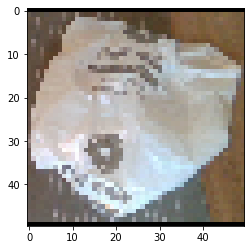

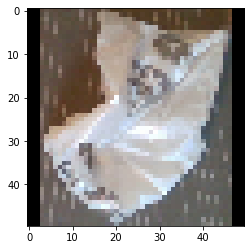

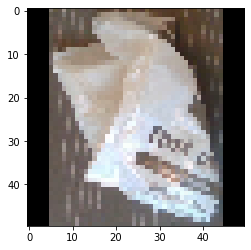

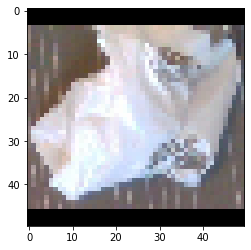

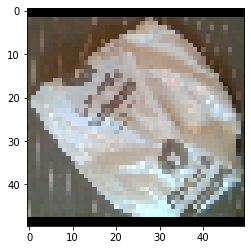

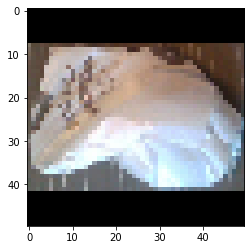

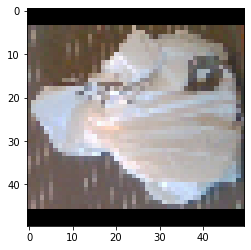

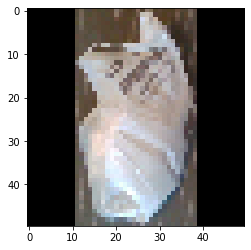

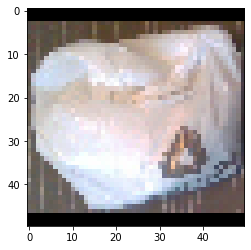

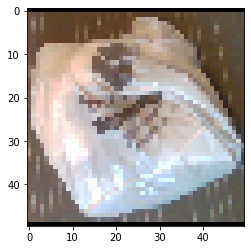

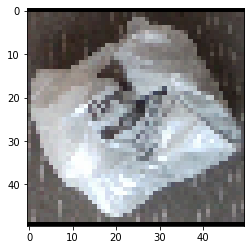

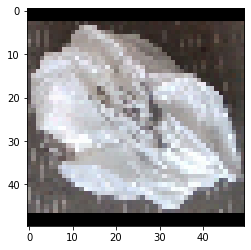

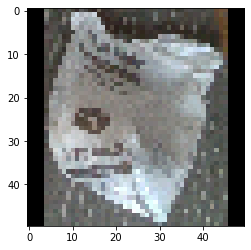

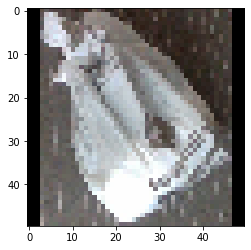

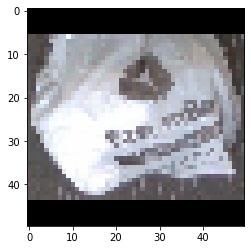

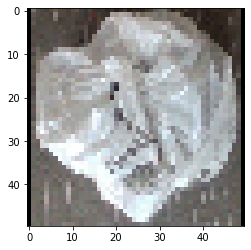

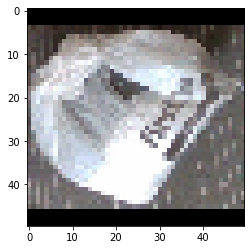

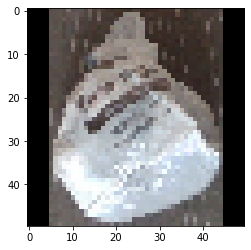

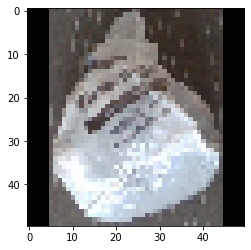

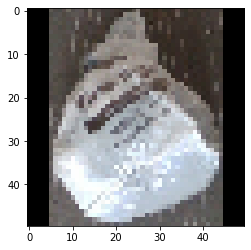

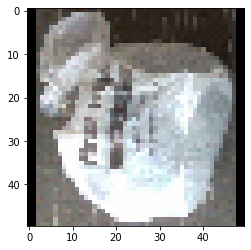

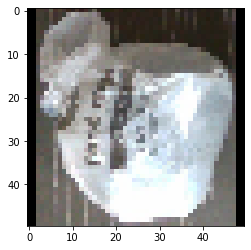

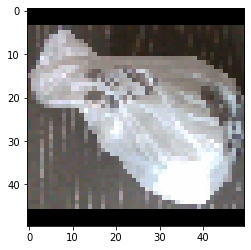

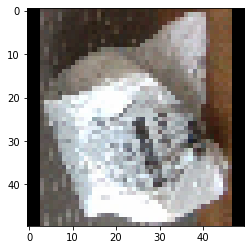

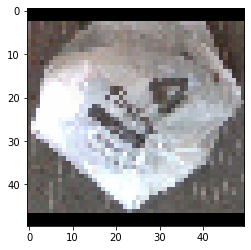

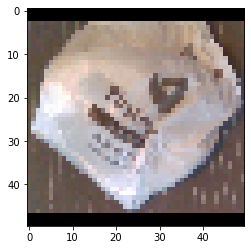

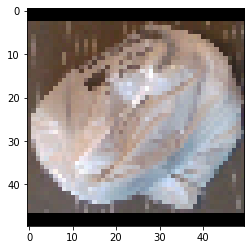

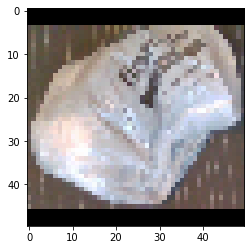

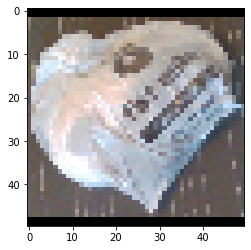

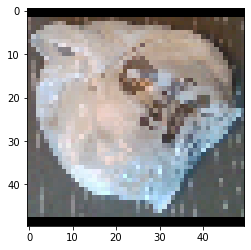

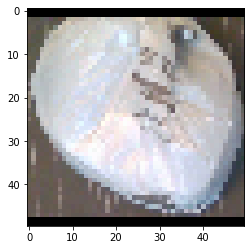

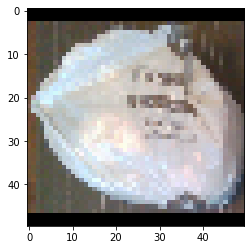

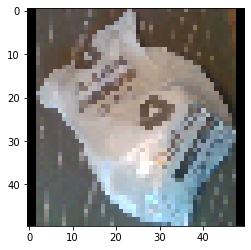

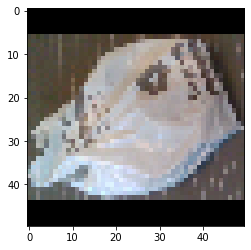

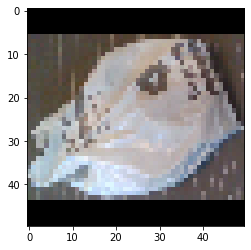

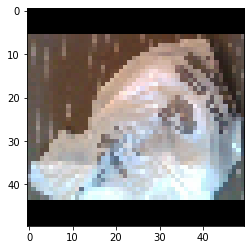

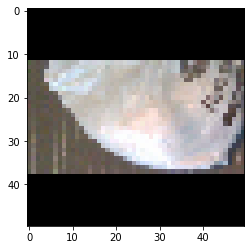

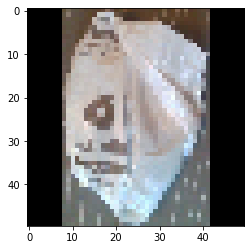

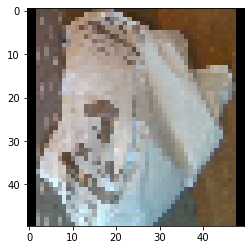

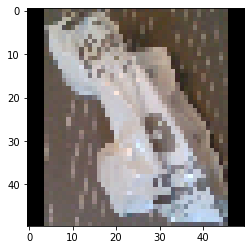

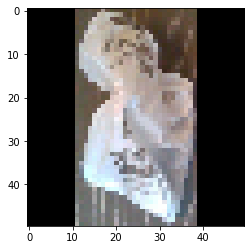

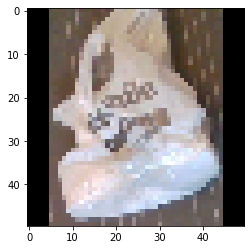

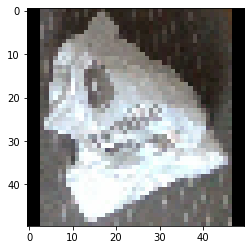

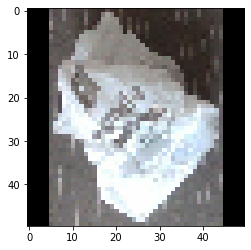

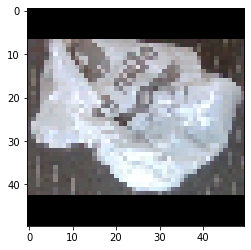

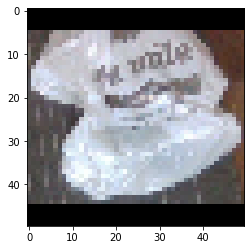

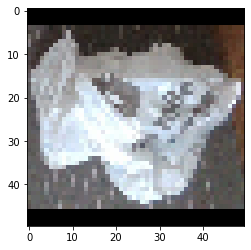

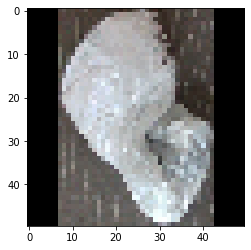

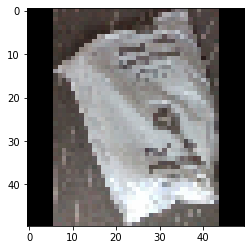

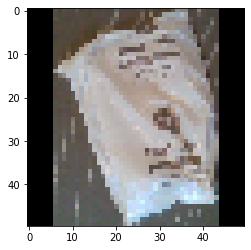

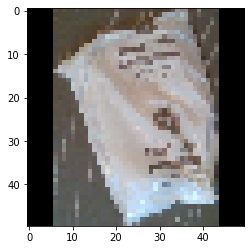

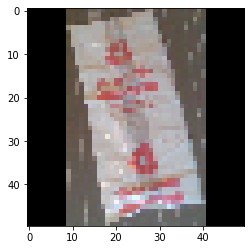

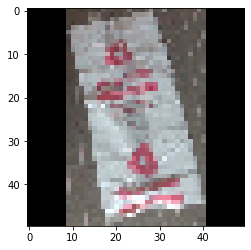

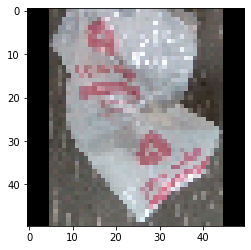

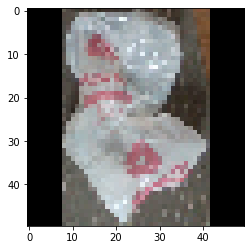

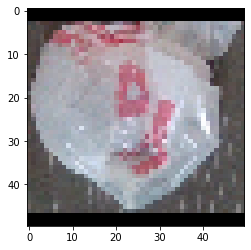

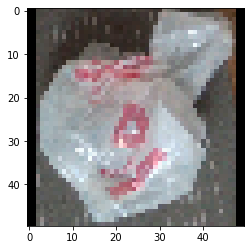

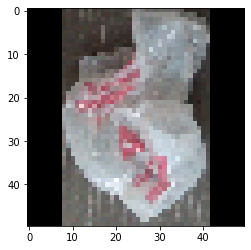

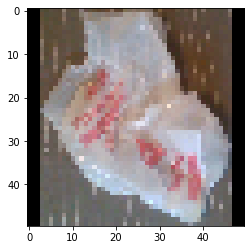

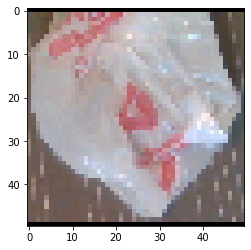

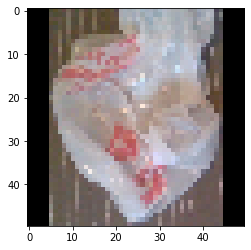

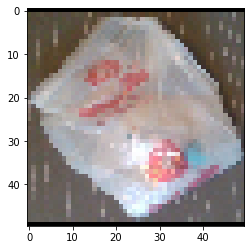

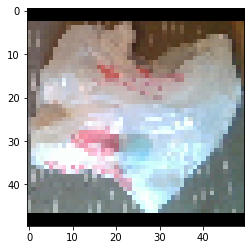

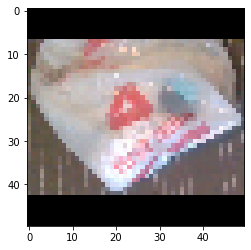

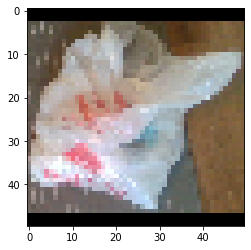

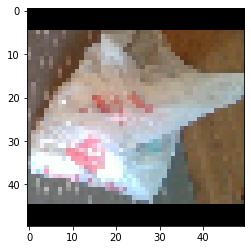

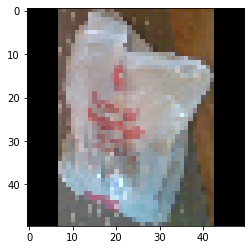

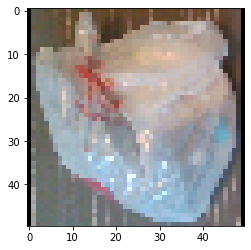

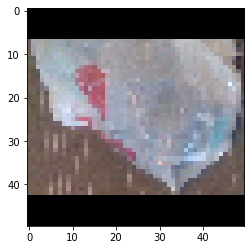

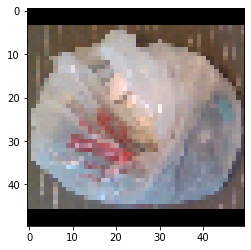

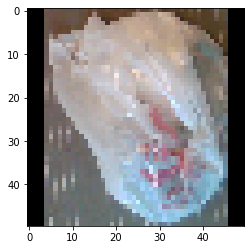

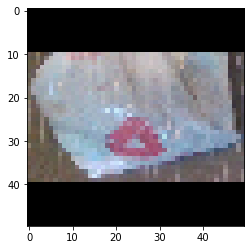

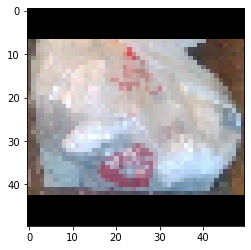

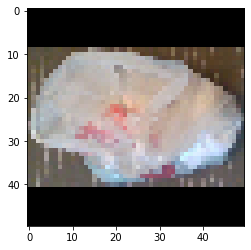

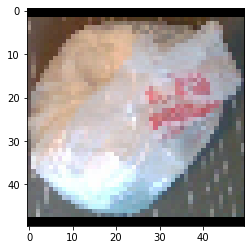

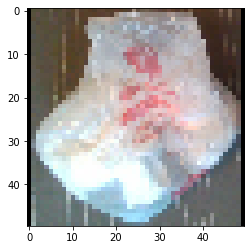

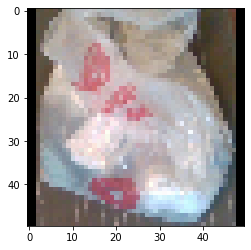

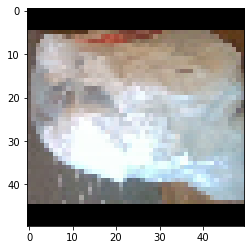

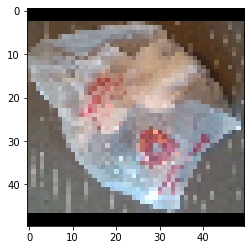

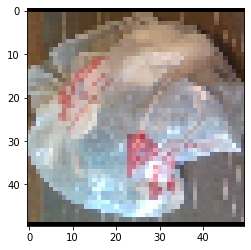

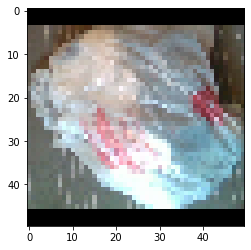

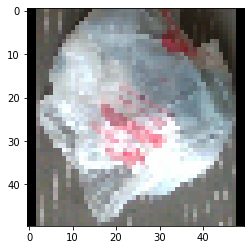

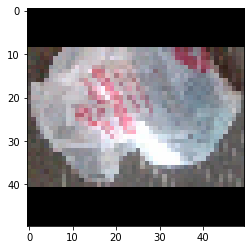

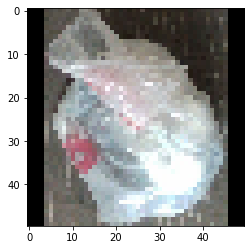

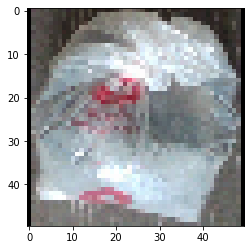

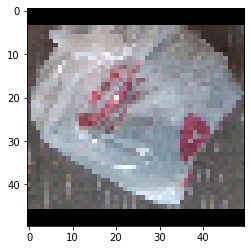

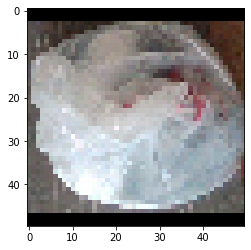

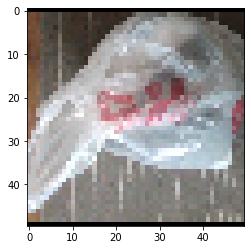

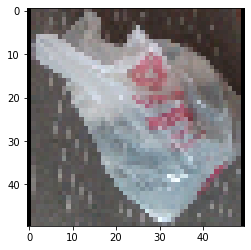

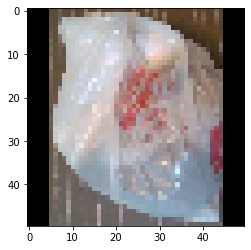

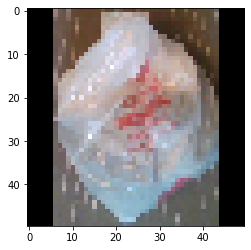

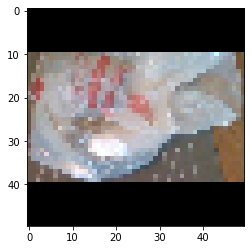

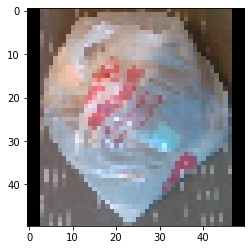

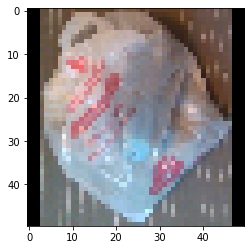

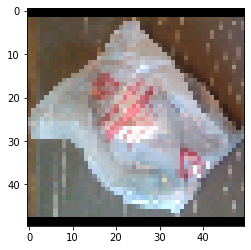

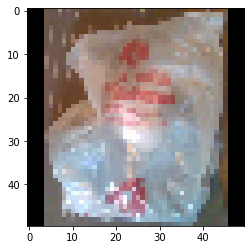

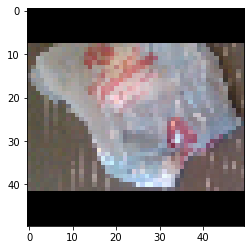

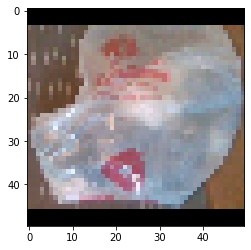

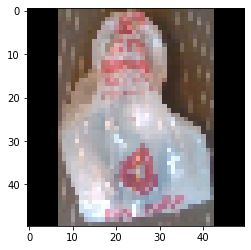

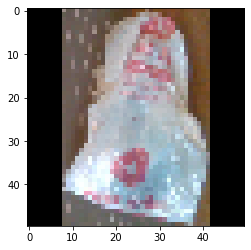

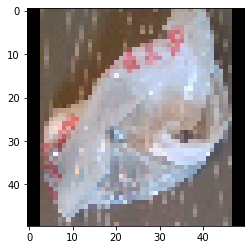

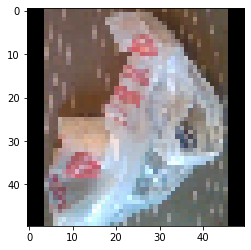

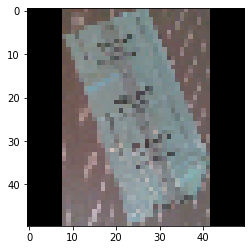

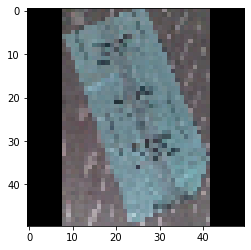

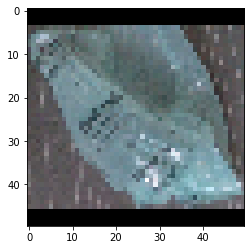

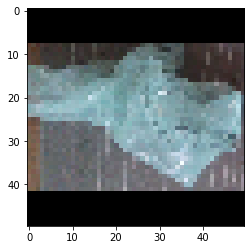

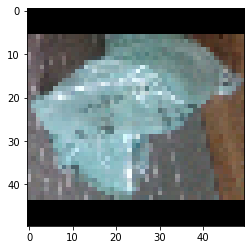

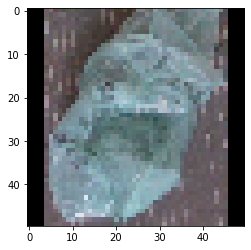

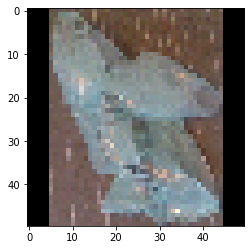

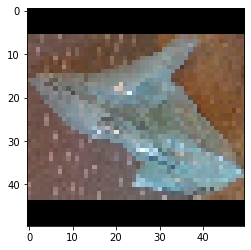

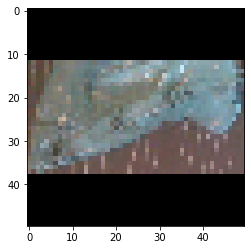

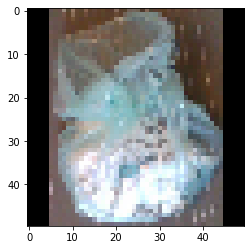

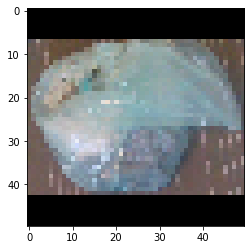

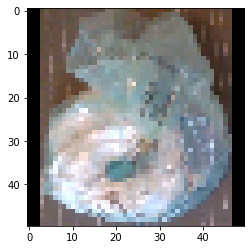

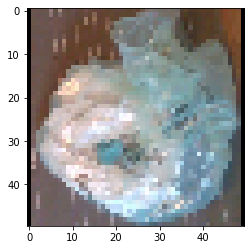

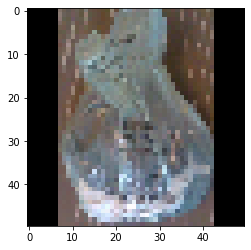

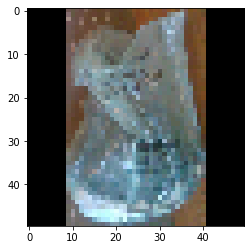

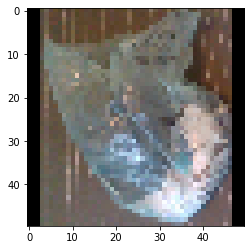

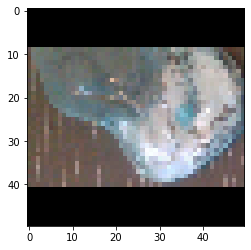

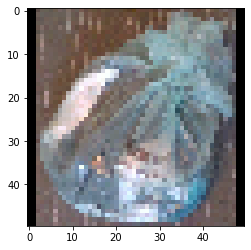

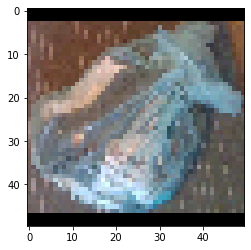

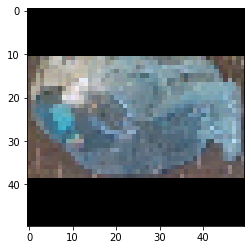

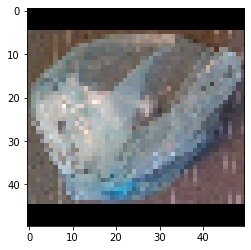

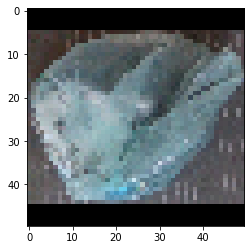

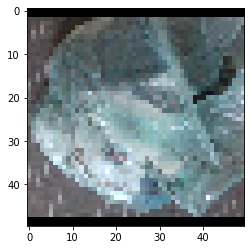

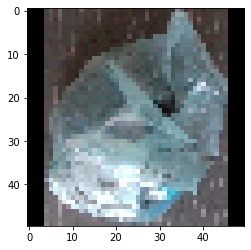

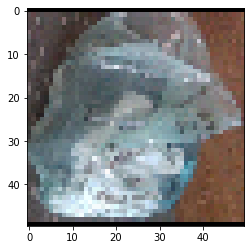

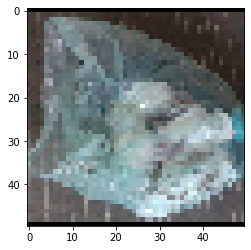

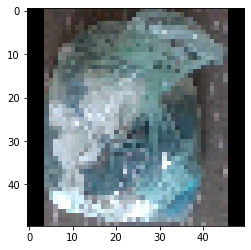

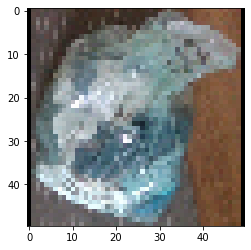

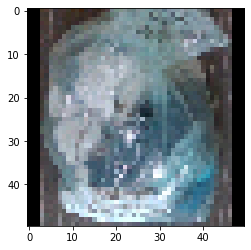

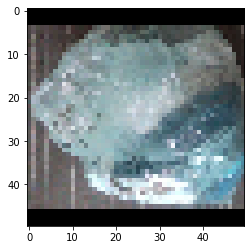

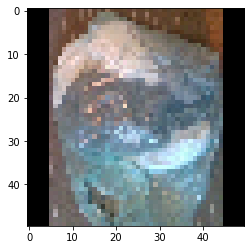

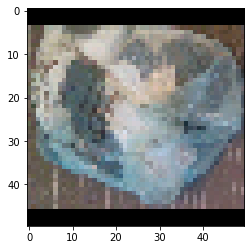

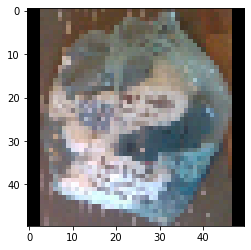

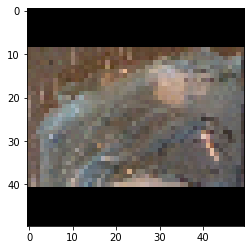

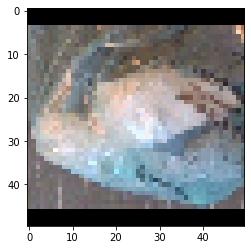

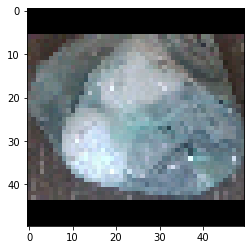

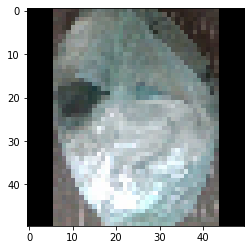

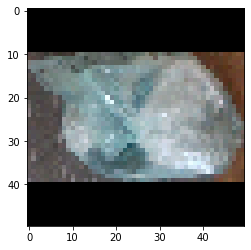

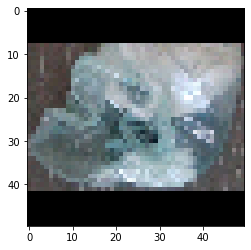

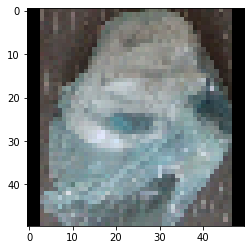

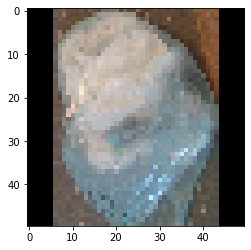

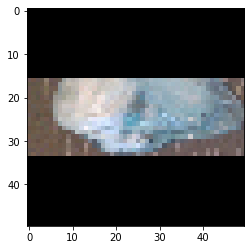

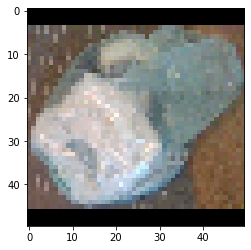

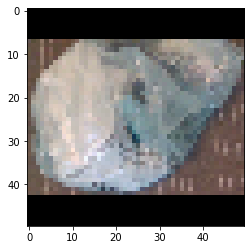

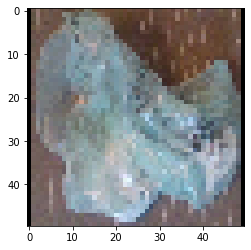

In [6]:
# Detect and save the bag images
for bag in bags:
    for index in range(len(full_paths[bag]['images'])):
        compare_image_background(index, 0, full_paths, bag=bag, blur=False)